In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# torch
import torch
from torch.utils.data import random_split
from pytorch_lightning.loggers import CSVLogger

# vision
from torchvision.transforms import v2 as T
from torchvision.utils import save_image

# utils
from copy import copy
#from tqdm import tqdm
import random

# custom utils
from datasets.dataset import *
from helper_utils import my_utils, display
from models.smp_model import CatSegModel
from models.model_utils import build_trainer, infer_set

In [3]:
# setup
torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Configuration
Load Configuration:

In [7]:
config_name = "Unet_efficientnet-b3_load.json"
paths, config = my_utils.load_configs(config_name, 'paths_laptop.json')

{
  "NAME": "Unet_efficientnet-b3_pretrained_DiceLoss",
  "MODE": "load"
}


### Data prep
Define transforms for the data:

In [30]:
# Example transformations
# @TODO: what is the corect image size
data_transforms = {}
data_transforms['train'] = T.Compose([
    T.RandomResizedCrop(size=640, scale=(0.5, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['valid'] = T.Compose([
    #T.Resize(670),
    T.CenterCrop(640),
    T.ToImage(),
    #T.ToDtype(torch.float32, scale=True)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_transforms['test'] = data_transforms['valid']

Build dataset:

In [9]:
#@TODO: 
# get files
full_dataset = SegmentationDataset(paths['train_data_root'])

# specify sizes
train_ratio = 0.7 # from total count
valid_ratio = 0.15 # from total count

# build datasets
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
valid_size = int(valid_ratio * total_size)
test_size = total_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])
train_dataset.dataset = copy(full_dataset) # disgusting solution for pytorch

# apply transforms
train_dataset.dataset.transform = data_transforms['train']
valid_dataset.dataset.transform = data_transforms['valid']
test_dataset.dataset.transform = data_transforms['test']

Plot a few images for example:

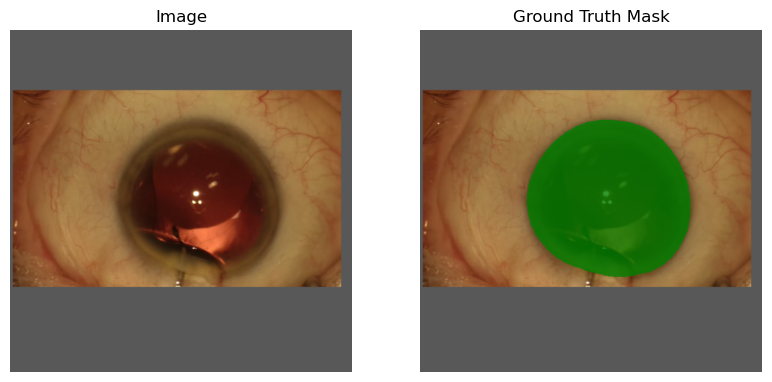

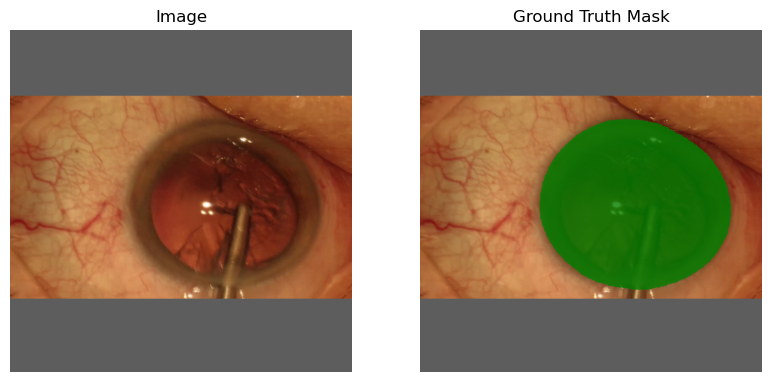

In [32]:
for _ in range(2):
    index = random.randint(0, len(test_dataset) - 1)
    display.display_sample(train_dataset, index)

In [11]:
# Generate files split
train_dl, valid_dl, test_dl =  build_dataloaders(train_dataset, valid_dataset, test_dataset, batch_size=2)

### Build model
Config load:

In [13]:
# build model
if config['MODE'] == 'train':
    model = CatSegModel(config)
    
elif config['MODE'] == 'load':
    # load model from checkpoint
    model = CatSegModel.load_from_checkpoint(
        checkpoint_path=os.path.join(paths['log_path'], config['NAME']+'_best-checkpoint.ckpt'),
        hparams_file=os.path.join(paths['log_path'], 'hparams.yaml')
    )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to models/torch\hub\checkpoints\efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:02<00:00, 18.6MB/s]


#### Build the PL trainer:

In [14]:
trainer, train_logger = build_trainer(config, paths)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Train and plot convergance:

In [15]:
plot_metrics = ['dataset_iou', 'dataset_loss']

if config['MODE'] == 'train':
    # train using the included logger
    trainer.fit(model, 
        train_dataloaders=train_dl, 
        val_dataloaders=valid_dl)
    
    if plot_metrics != None:
        pth = os.path.join(train_logger.log_dir, 'metrics.csv')
        display.plot_losses(pth, plot_metrics)

### Test and Evaluate

In [16]:
test_csv_logger = CSVLogger(paths['log_path'], 'test')
trainer.logger = test_csv_logger

with torch.no_grad():
    model.eval()
    trainer.test(model= model, dataloaders = test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jonathan\.conda\envs\custom_CatSemSeg\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test_dataset_iou        0.9787966012954712
    test_dataset_loss      0.011343351565301418
   test_per_image_iou        0.978985071182251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Test preformance:

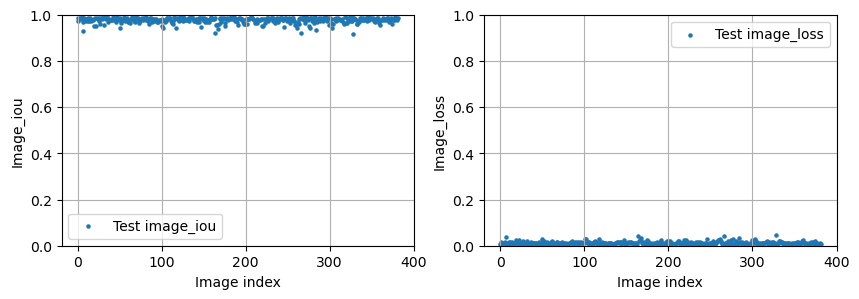

In [18]:
pth = os.path.join(paths['log_path'], 'test', 'metrics.csv')
display.plot_losses(pth, ['image_iou', 'image_loss'], test = True)

### Generate marked images
We will begin by generating the predicted masks on the test dataset, and save them to disk in `train_data_root\infer\NAME`.
Also, we will display a few images.

<Figure size 1500x500 with 0 Axes>

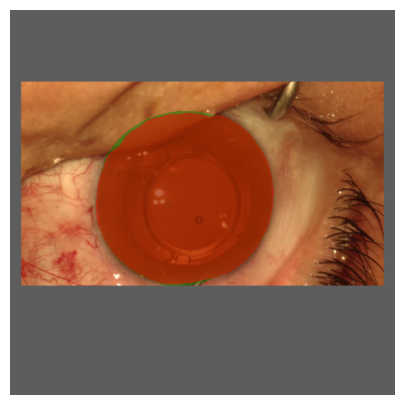

<Figure size 1500x500 with 0 Axes>

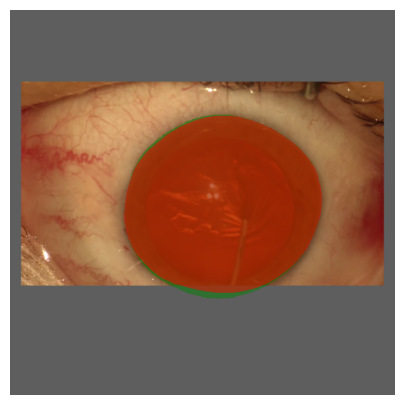

<Figure size 1500x500 with 0 Axes>

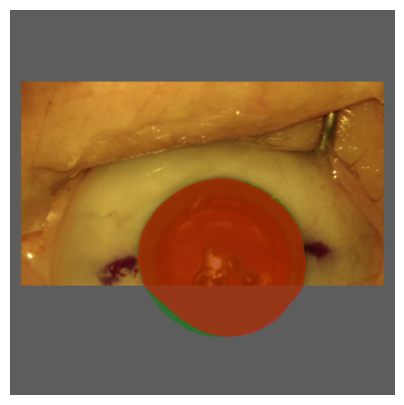

In [29]:
pth = os.path.join(paths['train_data_root'], 'infer', config['NAME'])
infer_set(model, device, pth, dataset=test_dl.dataset, save=False, print=3)

#### Test Data
For qualiative evaluation we will generate and display images from out-of-dataset.

First we need to load the inference dataset `infer_dataset`:

In [22]:
data_transforms['infer'] = T.Compose([
    T.Resize((640 - 256, 640 - 32)),
    T.Pad([16, 128, 16, 128], (0.5, 0.5, 0.5)),
    T.CenterCrop(640),
    T.ToImage(),
    T.ToDtype(torch.uint8, scale=True),
])

In [23]:
# build dataset
infer_dataset = SegmentationInferenceDataset(paths['inference_data_root'], transform=data_transforms['infer'], is_stereo=True)

Generate the masks:

<Figure size 1500x500 with 0 Axes>

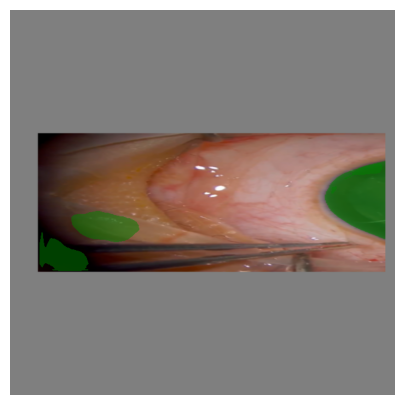

<Figure size 1500x500 with 0 Axes>

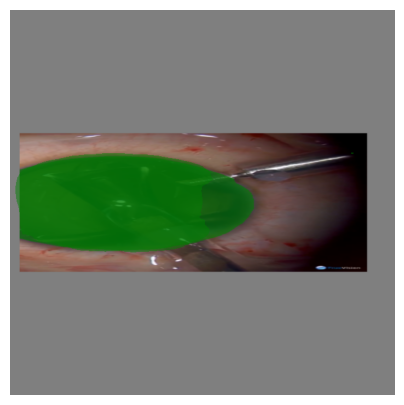

<Figure size 1500x500 with 0 Axes>

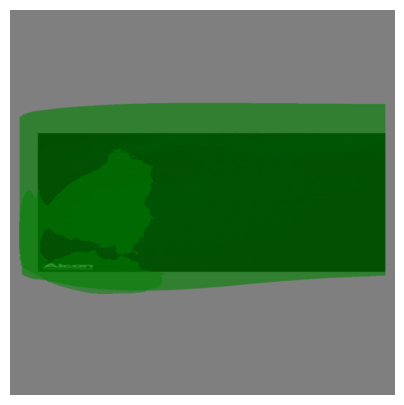

<Figure size 1500x500 with 0 Axes>

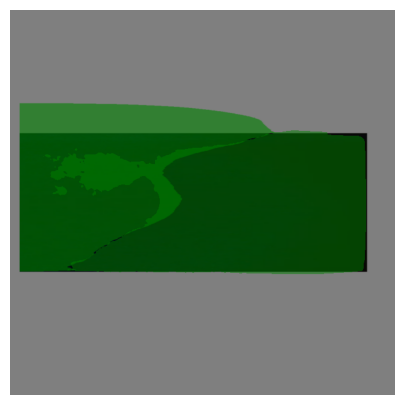

<Figure size 1500x500 with 0 Axes>

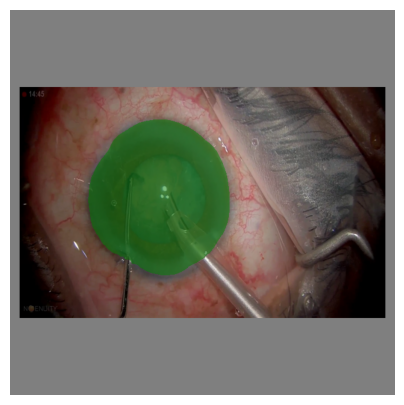

In [26]:
pth = os.path.join(paths['inference_save_path'])
infer_set(model, device, pth, dataset=infer_dataset, save=True, print=5)